# Activity Feed Details - Web Scraping

>- It can be used free account to extract the information
>- For this script you can use either a list of logins, or setup a unique login through the **Function** `change_user ()`, with `number_logins=1` and any login of your choice
>- For a web scraping process is important to have a exception when the internet connection is lost, for this was created the **Function** `connect()` that tests the connection before each Action, and a loop while in each Action too to garantee to scrap all the information

The last update was at February, 18, 2021

Through the URL bellow it's possible to access each month, with all activities, athlete by athlete. 

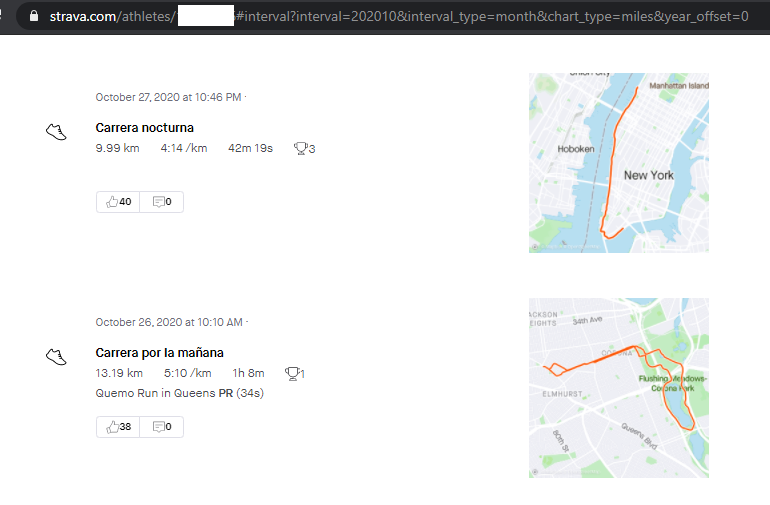

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Environment" data-toc-modified-id="Environment-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Environment</a></span></li></ul></li><li><span><a href="#Import-personal-data" data-toc-modified-id="Import-personal-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import personal data</a></span></li><li><span><a href="#Steps-functions" data-toc-modified-id="Steps-functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Steps functions</a></span></li><li><span><a href="#Informations-to-scrap" data-toc-modified-id="Informations-to-scrap-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Informations to scrap</a></span></li><li><span><a href="#Create-session,-open-page-and-change-language-to-English" data-toc-modified-id="Create-session,-open-page-and-change-language-to-English-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Create session, open page and change language to English</a></span></li><li><span><a href="#Scraping" data-toc-modified-id="Scraping-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Scraping</a></span></li></ul></div>

## Setup

In [ ]:
import time
import datetime
from selenium import webdriver
from selenium.webdriver.support.ui import Select
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import pyversions  # https://pypi.org/project/pyversions/
import sys, os
import urllib.request
import re
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import NoSuchElementException
pyversions.versions();

### Environment

In [ ]:
#parameters
id_login=0 #choose the first index in the logins list to rotate the accesses
number_logins = 1 #choose the number of logins to use
first_athlete=0 #variable to indicate the first position in the athletes list
last_athlete=1 #variable to indicate the last position in the athletes list
import_strava ="NEW YORK.csv" #input list with all the athletes to scrap details informations

In [ ]:
#It´s used a group of logins to access the Strava plataform and scraping the information
#id_login it´s the first index to rotate logins

path2 = r'../Datasets'
logins=pd.read_excel(os.path.join(path2,'logins.xlsx'))

count_logins = 1
aux_id = id_login #variable used to compare the current position of the index with the initial
export = str(first_athlete)+'-'+str(last_athlete)+'.csv'
options = webdriver.ChromeOptions() #setup chromeoptions - loading images = False | This configuration optimize the loading page
prefs = {"profile.managed_default_content_settings.images": 2}
options.add_experimental_option("prefs", prefs)

In [ ]:
logins.columns

## Import personal data

In [ ]:
athletes_list = pd.read_csv(os.path.join(path2,import_strava),sep=';',nrows=1)
athletes_list.columns

In [ ]:
usecols = [6,7,8,9,10]
athletes_list = pd.read_csv(os.path.join(path2,import_strava),sep=';',
                            usecols=usecols,
                            encoding='utf-8', verbose=False)
athletes_list

## Steps functions

In [ ]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

Bellow the list of functions with their descriptions:

- **open_section** - create a new instance for selenium webdriver, and load the login page
- **login** - fill down the form and click
- **user_access** - kill the session and starts a new one with other logins, works together with **change_user" function
- **change_user** - this function changes the logged user if you have a list of logins. It's import to avoid 429 error (too many requests)
- **select_english_language** - to scrap all the information in English, this function changes the language view to English
- **go_link** - It's used to load the segments page
- **create_dataset** - organize the informations and save a **.csv** file
- **connect** - check the Internet connection, there a loop while to wait the Internet connection
- **page_loaded** - check if the page was loaded, the process check if the page response is "The requested athlete could not be found", this happens when the athlete doesn't  bellow anymore to the Strava. And checks also if there is a "-" in the response, sometimes when the page is loading, shows the week information instead of month information.

For example: the response shows "Activities for Oct 26, 2020 - Nov 1, 2020" instead of "Activities for Nov 2020"


- **scraping:** activities information are stored in this part. Each variable with their description are bellow, from the first to fourth variable (gender, segment, athlete_id and age_group) are from csv source file

| VARIABLE     | DESCRIPTION                        |
|--------------|------------------------------------|
| gender       | M / F                              |
| segment      | URL link from source segment       |
| athlete_id   | URL link from athlete page         |
| age_group    | information from segments scraping |
| date_utc     | UTC time                           |
| datetime     | local time                         |
| activity     | one of 37 types of sport           |
| activity_id  | URL link from each activity        |
| distance     | distance from each activity        |
| pace         | pace from each activity            |
| duration     | duration from each activity [HH:MM]        |
| heart_rate   | mean heart rate from each activity |
| context      | activity done in group or single   |
| challenge    | flag to race activities            |
| kudos        | kudos given by friends             |
| achievements | number of achievements             |
| calories     | calories in [cal]                  |
| elevation    | elevation in [m]                   |


- **sports** - Until this date, we have mapped a group of sports, Strava can create others, for this reason, there is an option to append it that takes the entire description. This is the last "else"

In [ ]:
from ipynb.fs.defs.webscrap_athletes import login, open_section, change_user, select_english_language,\
    go_link, connect

def page_loaded(driver,url):
    
    print('Page loaded?')
    CRED = '\033[92m'
    CEND = '\033[0m'
    while True:
        connect()
        # ERROR - The requested athlete could not be found
        try:
            loading_page_error = driver.find_element_by_xpath('//*[@id="system-messages-js"]/div/div/div')
            loading_page_html_error=loading_page_error.get_attribute('innerHTML')
            loading_page_soup_error=BeautifulSoup(loading_page_html_error, "html.parser")

            if re.search('The requested athlete could not be found',str(loading_page_soup_error),re.IGNORECASE):
                print(CRED+'The requested athlete could not be found !!!!'+CEND)
                break

        except:
            # Loading page
            try:
                loading_page = driver.find_element_by_xpath('//*[@id="interval-value"]')
                loading_page_html=loading_page.get_attribute('innerHTML')
                loading_page_soup=BeautifulSoup(loading_page_html, "html.parser")

                if re.search('-',str(loading_page_soup),re.IGNORECASE):
                    go_link(driver,url)
                    time.sleep(5)
                    continue
                else:
                    print(CRED+'OKAY !!!!'+CEND)
                    break

            except: 
                go_link(driver,url)
                continue
                
def user_access(driver,url):
    global count_logins
    global aux_id
    
    if count_logins%3==0 and number_logins>1: #check if there is more than 1 login and the number of logins up to the limit for another
        
        connect()
        driver.close()
        driver.quit()
        
        aux_id = aux_id + 1
        if (aux_id - id_login)>=number_logins:
            aux_id = id_login
        
        driver = open_section()
        email, key = change_user(aux_id,logins)
        login(driver,email, key)
        select_english_language(driver,aux_id)
        go_link(driver,url=url)
        
    
    count_logins=count_logins+1
    return driver

def scraping(driver,athlete,url):
    global results
    
    #global athlete_name
    global athlete_gender
    global athlete_segment_source
    global athlete_id
    global athlete_age_group
    global athlete_major

    global activity_single_group
    global date_class_utc
    global date_class_localtime
    global sport_type
    global activity_id
    #global activity_name
    global activity_distance
    global activity_pace
    global activity_time
    global activity_heart_rate
    global activity_training_challenge
    global activity_kudos
    global activity_achievements
    global activity_calories
    global activity_elevation
        
    while True:
        
        aux_distance=0
        aux_pace=0
        aux_time=0
        aux_hear_rate=0
        aux_activity_training_challenge=0
        aux_activity_achievements=0
        aux_activity_calories=0
        aux_activity_elevation=0
        
        try:
            connect()
            information = driver.find_element_by_xpath('//*[@id="interval-rides"]/div')
            html=information.get_attribute('innerHTML')
            soup = BeautifulSoup(html, "html.parser")
            
    #_______________________ #FEED OF ACTIVITIES ______________________________________________________________________
            type_feed = [soup.find_all('div',class_='activity entity-details feed-entry'),
                      soup.find_all('div',class_='feed-entry group-activity'),
                      soup.find_all('div',class_='activity entity-details feed-entry min-view')]

            for alone_group in range(3): 
                    for feed in type_feed[alone_group]:

    #_______________________ ATHLETE INFORMATION ______________________________________________________________________
                        athlete_gender.append(athletes_list['gender'][athlete])
                        athlete_segment_source.append(athletes_list['url_activity'][athlete])
                        athlete_id.append(athletes_list['url_athlete'][athlete])
                        athlete_age_group.append(athletes_list['age_group'][athlete])
                        athlete_major.append(athletes_list['major'][athlete])

    #_______________________ CONTEXT - SINGLE OR GROUP ________________________________________________________________
                        if(alone_group==1):
                            activity_single_group.append('group')
                        else:
                            activity_single_group.append('single')

    #_______________________ DATETIME - LOCALTIME AND UTC _____________________________________________________________
                        date_class_utc.append(re.sub(r' UTC','',feed.find('time',class_='timestamp')['datetime']))
                        date_class_localtime.append(re.sub(r'\n','',feed.find('time',class_='timestamp').get_text()))

    #_______________________SPORTS ____________________________________________________________________________________
                        sport_type_class_alone = feed.find('h3',class_='entry-title activity-title') #.find('span',class_='app-icon-wrapper')
                        sport_type_class_group = feed.find('h4',class_='entry-title')


                        if (re.search('-run',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-run',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('run')
                            #aux_sport='running'

                        elif (re.search('-ride',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-ride',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('ride')
                            #aux_sport='cycling'

                        elif (re.search('-weighttraining',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-weighttraining',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('weighttraining')
                            #aux_sport='weighttraining'

                        elif (re.search('-workout',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-workout',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('workout')
                            #aux_sport='workout'

                        elif (re.search('-swim',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-swim',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('swim')
                            #aux_sport='swim'

                        elif (re.search('-elliptical',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-elliptical',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('elliptical')
                            #aux_sport='elliptical'

                        elif (re.search('-hike',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-hike',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('hike')
                            #aux_sport='hiking'


                        elif (re.search('-nordicski',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-nordicski',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('nordicski')

                        elif (re.search('-walk',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-walk',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('walk')

                        elif (re.search('-alpineski',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-alpineski',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('alpineski')

                        elif (re.search('-backcountryski',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-backcountryski',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('backcountryski')

                        elif (re.search('-canoeing',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-canoeing',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('canoeing')

                        elif (re.search('-crossfit',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-crossfit',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('crossfit')

                        elif (re.search('-ebikeride',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-ebikeride',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('ebikeride')

                        elif (re.search('-handcycle',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-handcycle',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('handcycle')

                        elif (re.search('-iceskate',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-iceskate',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('iceskate')

                        elif (re.search('-inlineskate',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-inlineskate',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('inlineskate')

                        elif (re.search('-kayaking',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-kayaking',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('kayaking')

                        elif (re.search('-kitesurf',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-kitesurf',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('kitesurf')

                        elif (re.search('-rockclimbing',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-rockclimbing',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('rockclimbing')

                        elif (re.search('-rollerski',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-rollerski',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('rollerski')

                        elif (re.search('-rowing',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-rowing',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('rowing')

                        elif (re.search('-snowboard',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-snowboard',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('snowboard')

                        elif (re.search('-snowshoe',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-snowshoe',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('snowshoe')

                        elif (re.search('-stairstepper',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-stairstepper',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('stairstepper')

                        elif (re.search('-standuppaddling',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-standuppaddling',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('standuppaddling')

                        elif (re.search('-surfing',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-surfing',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('surfing')

                        elif (re.search('-velomobile',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-velomobile',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('velomobile')

                        elif (re.search('-virtualride',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-virtualride',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('virtualride')

                        elif (re.search('-virtualrun',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-virtualrun',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('virtualrun')

                        elif (re.search('-wheelchair',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-wheelchair',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('wheelchair')

                        elif (re.search('-windsurf',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-windsurf',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('windsurf')

                        elif (re.search('-yoga',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-yoga',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('yoga')

                        elif (re.search('-golf',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-golf',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('golf')

                        elif (re.search('-soccer',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-soccer',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('soccer')

                        elif (re.search('-seal',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-seal',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('seal')

                        elif (re.search('-watersport',str(sport_type_class_alone),re.IGNORECASE)) or (re.search('-watersport',str(sport_type_class_group),re.IGNORECASE)):
                            sport_type.append('watersport')                       
                        else:
                            sport_type.append(re.sub(r'\n','',str(sport_type_class_alone)+str(sport_type_class_group)))

    #______________________ ACTIVITY ID AND ACTIVITY NAME _________________________________________________________________
                        if(alone_group==0 or alone_group==2):

                            #activity_name.append(re.sub(r'\n','',feed.find('h3',class_='entry-title activity-title').find('strong').text))
                            activity_id_aux = feed.find('h3',class_='entry-title activity-title').find('strong')
                        else:
                            #activity_name.append(re.sub(r'\n','',feed.find('h4',class_='entry-title').find('strong').text))
                            activity_id_aux = feed.find('h4',class_='entry-title').find('strong')

                        activity_id_aux = [c['href'] for c in activity_id_aux.find_all('a', href=True) if c.text]
                        activity_id.append('https://strava.com' + activity_id_aux[0] )

    #______________________ ACTIVITY INFORMATIONS _________________________________________________________________________
                        activity_aux = feed.find('ul',class_='inline-stats list-stats')
                        activity = [t.text.strip() for t in activity_aux.findAll("li")][0:] #It´s necessary to validade information with more than 3 columns, for example "distance, pace, time, pride" or "competition, distance, pace, time, pride"
                        activity_information_name = [t.get('title') for t in activity_aux.findAll("li")]

                        for information_column in range(len(activity)):

                            #if re.search(' km',str(activity[information_column]),re.IGNORECASE):
                            if re.search('Distance',str(activity_information_name[information_column]),re.IGNORECASE):
                                activity_distance.append(activity[information_column])
                                aux_distance=1

                            #if re.search(' /km',str(activity[information_column]),re.IGNORECASE):
                            if re.search('Pace',str(activity_information_name[information_column])):    
                                activity_pace.append(activity[information_column])
                                aux_pace=1

                            #if (re.search('min',str(activity[information_column]),re.IGNORECASE)):
                            if (re.search('Time',str(activity_information_name[information_column]))):    
                                time_manipulation=re.sub(r'(\d+)(h)( )(\d+)(min)', r'\1:\4:00',str(activity[information_column]))
                                time_manipulation=re.sub(r'(\d+)(min)( )(\d+)(s)', r'00:\1:\4',time_manipulation)
                                activity_time.append(time_manipulation)
                                aux_time=1

                            #if (re.search('bpm',str(activity[information_column]),re.IGNORECASE)):
                            if (re.search('Avg HR',str(activity_information_name[information_column]))):    
                                activity_heart_rate.append(activity[information_column]) 
                                aux_hear_rate=1

                            if (re.search('Race',str(activity[information_column]),re.IGNORECASE)):
                                activity_training_challenge.append(str(activity[information_column]).lower()) 
                                aux_activity_training_challenge=1

                            if (re.search('Achievements',str(activity[information_column]),re.IGNORECASE)):
                                activity_achievements.append(re.sub(r'Achievements','',re.sub(r'\n','',activity[information_column]))) 
                                aux_activity_achievements=1

                            #if (re.search('Kcal',str(activity[information_column]),re.IGNORECASE)):
                            if (re.search('Cal',str(activity_information_name[information_column]))):    
                                activity_calories.append(activity[information_column])
                                aux_activity_calories=1

                            #if (re.search(' m',str(activity[information_column]),re.IGNORECASE)):
                            if (re.search('Elev Gain',str(activity_information_name[information_column]))):    
                                activity_elevation.append(activity[information_column])
                                aux_activity_elevation=1



                        if(aux_distance==0): 
                            activity_distance.append(np.nan)
                        if(aux_pace==0):
                            activity_pace.append(np.nan)
                        if(aux_time==0):
                            activity_time.append(np.nan)
                        if(aux_hear_rate==0):
                            activity_heart_rate.append(np.nan)
                        if(aux_activity_training_challenge==0):
                            activity_training_challenge.append(np.nan)
                        if(aux_activity_achievements==0):
                            activity_achievements.append(np.nan)
                        if(aux_activity_calories==0):
                            activity_calories.append(np.nan)
                        if(aux_activity_elevation==0):
                            activity_elevation.append(np.nan)

                        aux_distance=0
                        aux_pace=0
                        aux_time=0
                        aux_hear_rate=0
                        aux_activity_training_challenge=0
                        aux_activity_achievements=0
                        aux_activity_calories=0
                        aux_activity_elevation=0

    #______________________ KUDOS ________________________________________________________________________________________
                        activity_kudos.append(feed.find('span',class_='count count-kudos').get_text())


            break
        
        except:
            print('3')
            go_link(driver,url=url)
            continue         
            
    print('Scraping...')

def create_dataset():
        
    #df_athlete_name=pd.DataFrame(athlete_name,columns=['athlete_name'])
    df_athlete_gender=pd.DataFrame(athlete_gender,columns=['gender'])
    df_athlete_segment_source=pd.DataFrame(athlete_segment_source,columns=['segment'])
    df_athlete_id=pd.DataFrame(athlete_id,columns=['athlete_id'])
    df_athlete_age_group=pd.DataFrame(athlete_age_group,columns=['age_group'])


    df_activity_single_group=pd.DataFrame(activity_single_group,columns=['context'])
    df_date_class_utc=pd.DataFrame(date_class_utc,columns=['date_utc'])
    df_date_class_localtime=pd.DataFrame(date_class_localtime,columns=['datetime'])        
    df_sport_type=pd.DataFrame(sport_type,columns=['activity'])
    df_activity_id=pd.DataFrame(activity_id,columns=['activity_id'])
    #df_activity_name=pd.DataFrame(activity_name,columns=['activity_name'])
    df_activity_distance=pd.DataFrame(activity_distance,columns=['distance'])
    df_activity_pace=pd.DataFrame(activity_pace,columns=['pace'])
    df_activity_time=pd.DataFrame(activity_time,columns=['duration'])
    df_heart_rate=pd.DataFrame(activity_heart_rate,columns=['heart_rate'])
    df_activity_training_challenge=pd.DataFrame(activity_training_challenge,columns=['challenge'])
    df_activity_kudos=pd.DataFrame(activity_kudos,columns=['kudos'])
    df_activity_achievements=pd.DataFrame(activity_achievements,columns=['achievements'])
    df_activity_calories=pd.DataFrame(activity_calories,columns=['calories'])
    df_activity_elevation=pd.DataFrame(activity_elevation,columns=['elevation'])
    df_major=pd.DataFrame(athlete_major,columns=['major'])

    df=pd.concat([df_athlete_gender,df_athlete_segment_source,df_athlete_id,
                  df_athlete_age_group,df_date_class_utc,df_date_class_localtime,
                  df_sport_type,df_activity_id,df_activity_distance,
                  df_activity_pace,df_activity_time,df_heart_rate,df_activity_single_group,
                  df_activity_training_challenge,df_activity_kudos,df_activity_achievements,
                  df_activity_calories,df_activity_elevation],axis=1)
    
    df.to_csv(export,index=False,sep=';')
    print('Dataset created')

## Informations to scrap

In [ ]:
months={'1':'01','2':'02','3':'03','4':'04','5':'05','6':'06','7':'07','8':'08','9':'09','10':'10','11':'11','12':'12'}
results = []
athlete_name = []
athlete_gender = []
athlete_segment_source = []
athlete_id = []
athlete_age_group = []
athlete_major = []

activity_single_group = []
date_class_utc = []
date_class_localtime = []
sport_type = []
activity_id = []
activity_name = []
activity_distance = []
activity_pace = []
activity_time = []
activity_heart_rate = []
activity_training_challenge = []
activity_kudos = []
activity_achievements = []
activity_calories = []
activity_elevation = []

## Create session, open page and change language to English

In [ ]:
driver = open_section()
email, key = change_user(id_login,logins)
login(driver,email, key)
select_english_language(driver,id_login)

## Scraping

In [ ]:
for athlete in range(first_athlete,last_athlete):
    for year in range(2019,2021):
            for month in range(1,13):
                CRED = '\033[1m'
                CEND = '\033[0m'

                print(CRED + 'Athlete - ' +str(athlete)+ " out of " + str(last_athlete) + " | Year - " + str(year) + " | Month - " + str(month)+ CEND)
                url = athletes_list['url_athlete'][athlete]+'#interval_type?chart_type=miles&interval_type=month&interval='+str(year)+months[str(month)]+'&year_offset=0'
                go_link(driver,url=url)
                page_loaded(driver,url)
                scraping(driver,athlete,url)
                
    create_dataset()            
    driver = user_access(driver,url)